# Modelo MS-MS para los cúmulos escogidos

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import re
import os
from scipy import stats
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import find_peaks


Consideremos la ecuación para la magnitud de un sistema binario (considerandolo como una fuente puntual) de Milone et al. 2018:

$$\mathrm{m_{bin}} = m_1 - 2.5 \log_{10}\left( 1 + \dfrac{F_2}{F_1}\right)$$

$$\mathrm{m_{bin}} = m_1 - 2.5 \log_{10}\left( 1 + \dfrac{L_2}{L_1}\right)$$

$$\mathrm{m_{bin}} = m_1 - 2.5 \log_{10}\left( 1 + \left[ \dfrac{M_2}{M_1} \right]^{3.5}\right)$$
$$\mathrm{m_{bin}} = m_1 - 2.5 \log_{10}\left( 1 + q^{3.5}\right)$$

In [2]:
def m_bin(m1, q):
    return m1 - 2.5 * np.log10(1 + q**(3.5))

In [3]:
df_ngc2808 = pd.read_csv('data/ngc2808.csv').dropna(subset=['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
df_ngc4755 = pd.read_csv('data/ngc4755.csv').dropna(subset=['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
df_ngc6694 = pd.read_csv('data/ngc6694.csv').dropna(subset=['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])

df_ngc2808 = df_ngc2808.rename(columns={'phot_g_mean_mag': 'g', 'phot_bp_mean_mag': 'bp', 'phot_rp_mean_mag': 'rp'})
df_ngc4755 = df_ngc4755.rename(columns={'phot_g_mean_mag': 'g', 'phot_bp_mean_mag': 'bp', 'phot_rp_mean_mag': 'rp'})
df_ngc6694 = df_ngc6694.rename(columns={'phot_g_mean_mag': 'g', 'phot_bp_mean_mag': 'bp', 'phot_rp_mean_mag': 'rp'})

df_ngc2808

,source_id,ra,dec,parallax,pmra,pmdec,ruwe,g,bp,rp,...,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,azero_gspphot,ag_gspphot,ebpminrp_gspphot
3,5248755528149120000,138.024296,-64.929135,0.070233,0.945825,0.371544,1.073403,18.299477,18.758608,17.574652,...,False,True,False,4796.1020,4.8934,-2.1899,1394.6476,0.0484,0.0382,0.0208
5,5248755532441537920,138.011478,-64.928911,-0.227482,0.856067,0.516022,0.911725,19.463888,19.545732,18.564917,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5248755532441556480,138.012653,-64.927123,0.046681,1.181902,0.238126,1.049162,18.189415,18.469221,17.374987,...,False,True,True,5560.9487,4.7307,-3.9982,1912.3499,0.7492,0.6110,0.3392
7,5248755532441572480,138.016231,-64.929577,0.274601,0.331386,1.090192,1.260872,19.316927,19.471746,18.530224,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5248755532441596160,138.018486,-64.929335,-0.212133,0.341646,0.492101,0.981523,19.746737,20.237011,19.366340,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21578,5248766149613510912,138.047601,-64.802394,0.060736,0.893860,1.670627,1.774715,18.851461,18.490362,17.469868,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21579,5248766149613516032,138.049931,-64.801332,0.215902,0.950468,0.096581,0.956090,17.445337,18.019041,16.770721,...,False,True,True,5249.2046,4.6777,-0.9837,1354.6202,0.7180,0.5753,0.3129
21580,5248766149613518208,138.053069,-64.801380,0.386951,0.160657,0.838170,1.040802,19.775116,19.923334,18.780573,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21581,5248766149613963264,138.043510,-64.801984,0.444670,0.575617,0.023597,0.969397,19.888430,20.703348,19.692366,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_ngc2808['g_bin'], df_ngc4755['g_bin'], df_ngc6694['g_bin'] = m_bin(df_ngc2808['g'], 0.5), m_bin(df_ngc4755['g'], 0.5), m_bin(df_ngc6694['g'], 0.5)
df_ngc2808['bp_bin'], df_ngc4755['bp_bin'], df_ngc6694['bp_bin'] = m_bin(df_ngc2808['bp'], 0.5), m_bin(df_ngc4755['bp'], 0.5), m_bin(df_ngc6694['bp'], 0.5)
df_ngc2808['rp_bin'], df_ngc4755['rp_bin'], df_ngc6694['rp_bin'] = m_bin(df_ngc2808['rp'], 0.5), m_bin(df_ngc4755['rp'], 0.5), m_bin(df_ngc6694['rp'], 0.5)

df_ngc4755



,source_id,ra,dec,parallax,pmra,pmdec,ruwe,g,bp,rp,...,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,azero_gspphot,ag_gspphot,ebpminrp_gspphot,g_bin,bp_bin,rp_bin
0,6055652344041076352,193.510441,-60.458254,-0.007594,-8.155732,-1.829909,1.370937,20.321098,20.855968,19.114860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.229138,20.764008,19.022900
1,6055652584547243904,193.468282,-60.453078,0.584574,-10.213827,-1.783573,0.962558,19.208470,20.232410,18.268274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.116510,20.140450,18.176314
2,6055652477159279872,193.433255,-60.469411,0.401651,-7.097710,-1.032569,1.016148,17.770750,18.448774,16.991890,...,4939.0730,4.7871,-1.4836,1046.6744,0.9739,0.7560,0.4110,17.678790,18.356814,16.899930
3,6055652477163000832,193.435895,-60.463539,0.369544,-10.964206,0.871068,0.966357,17.360992,17.988928,16.613853,...,4687.1147,4.3800,-1.2966,1539.9637,0.5575,0.4329,0.2351,17.269032,17.896968,16.521893
4,6055652477163000960,193.437947,-60.463675,0.454736,-5.686552,-1.001983,1.169018,17.967741,18.612896,17.073048,...,5280.6426,4.6946,-3.9461,1231.4875,1.4521,1.1352,0.6320,17.875781,18.520936,16.981088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13587,6056784119473282944,193.434669,-60.273891,0.231488,-8.292362,-0.107035,0.995060,18.033321,19.240692,16.944681,...,4593.9840,4.4896,-0.6253,871.7272,2.6991,1.9359,1.0554,17.941361,19.148732,16.852721
13588,6056784119473593856,193.437733,-60.277995,0.280377,-5.842338,0.648103,0.927769,17.092838,17.803577,16.264463,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.000878,17.711617,16.172503
13589,6056784119486858624,193.431654,-60.278818,0.545498,-7.693063,-1.227550,1.011728,19.453352,19.994776,18.261452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.361392,19.902816,18.169492
13590,6056784119487574528,193.447846,-60.272677,0.289127,-9.102897,-1.371390,1.095476,20.264935,21.266235,19.210377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.172975,21.174275,19.118417


In [5]:
df_isochrone = pd.read_csv('isochrone_tables.dat', sep='\s+', skiprows=13, header=0)
df_isochrone = df_isochrone[:-1]
df_isochrone


,#Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag
0,0.0152,0.01508,9.0,0.090000,1.081690,0.090,-3.384,3.3657,5.191,0.0,...,0.2756,0.002746,0.000741,0.006719,-1.000,0.01527,13.230,15.283,18.200,13.793
1,0.0152,0.01508,9.0,0.100000,1.171106,0.100,-3.222,3.3893,5.170,0.0,...,0.2757,0.002746,0.000741,0.006719,-1.000,0.01527,12.826,14.878,17.787,13.389
2,0.0152,0.01508,9.0,0.120000,1.319316,0.120,-2.975,3.4228,5.135,0.0,...,0.2757,0.002746,0.000741,0.006719,-1.000,0.01527,12.208,14.181,16.968,12.710
3,0.0152,0.01508,9.0,0.122962,1.338531,0.123,-2.948,3.4259,5.131,0.0,...,0.2757,0.002746,0.000741,0.006719,-1.000,0.01527,12.140,14.067,16.791,12.608
4,0.0152,0.01508,9.0,0.140000,1.438453,0.140,-2.794,3.4430,5.102,0.0,...,0.2758,0.002746,0.000741,0.006719,-1.000,0.01527,11.755,13.453,15.870,12.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,0.0152,0.01508,9.0,2.310102,2.579717,0.752,4.010,3.3975,-1.154,8.0,...,0.3168,0.006066,0.002370,0.006149,8.262,0.01993,-5.255,-3.068,-1.158,-4.380
634,0.0152,0.01508,9.0,2.310104,2.579717,0.745,4.027,3.3965,-1.178,8.0,...,0.3168,0.006069,0.002370,0.006149,8.263,0.01993,-5.297,-3.106,-1.195,-4.418
635,0.0152,0.01508,9.0,2.310107,2.579717,0.738,4.032,3.4019,-1.167,8.0,...,0.3168,0.006072,0.002370,0.006149,8.264,0.01994,-5.311,-3.163,-1.263,-4.470
636,0.0152,0.01508,9.0,2.310110,2.579717,0.730,4.034,3.4125,-1.130,8.0,...,0.3168,0.006075,0.002370,0.006149,8.265,0.01994,-5.314,-3.247,-1.367,-4.544


Data-binning con los datos. Para realizar el binning, se tuve que asumir varias cosas:
1. Todas las estrellas que tuvieran una magnitud mayor a 20 fueron ignoradas. Esto porque no se condieran parte del cúmulo. Para hacer esto, se aplicó una máscara a los datos.
2. Las ramas secundarias que aparecen en los cúmulos abiertos tampoco se consideran como parte de los cúmulos.

## NGC 4755

In [6]:
mask_4755 = df_ngc4755['g'] < 20
xbins_4755 = np.arange(0.2, 2.3, 0.05)
bin_means4755, bin_edges4755, binnumber4755 = stats.binned_statistic((df_ngc4755['bp'] - df_ngc4755['rp'])[mask_4755], df_ngc4755['g'][mask_4755],
        statistic='median', bins=xbins_4755)
# Ajuste Gaussiano
kernel = Gaussian1DKernel(stddev=0.3)
bin_fit4755 = convolve(bin_means4755, kernel)

Por medio de una convolución, podemos crear una curva que representa el MSRL.

In [7]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    ax.scatter(df_ngc4755['bp'] - df_ngc4755['rp'], df_ngc4755['g'], s=0.1, alpha=0.4)
    ax.hlines(bin_means4755, bin_edges4755[:-1], bin_edges4755[1:], lw=2, color='green', label=r'Bins (Data-Binning)', linewidth=1)
    ax.plot(xbins_4755[1:], bin_fit4755, c='b', label=r'Isocrona Ajustada')

    # Ploteamos la secuencia sobre la cual consideraremos un sistema binario correctamente resuelto q=0.7
    ax.plot(xbins_4755[1:], m_bin(bin_fit4755, 0.7), linestyle='solid', label=r'Región límite de MS $q=0.7$')
    ax.set_title('Diagrama HR - NGC 4755')
    ax.set_xlabel('BP - RP')
    ax.set_ylabel('$M_{G}$')
    ax.set_xlim(0, 2.5)
    ax.set_ylim(10, 20)
    ax.invert_yaxis()
    fig.tight_layout()
    ax.legend(loc='upper right')
    fig.savefig('figures/isochrone_ngc4755.jpg', dpi=600)
    plt.close()

Aquí se usó el hecho que estamos ocnsiderando una fracción de masa $q=0.7$ para representar la secuencia de corte para las cuales un sistema binario esta correctamente resuelto.

## NGC 6694

In [8]:
mask_6694 = df_ngc6694['g'] < 19
xbins_6694 = np.arange(0.65, 1.9, 0.03)
bin_means6694, bin_edges6694, binnumber6694 = stats.binned_statistic((df_ngc6694['bp'] - df_ngc6694['rp'])[mask_6694], df_ngc6694['g'][mask_6694],
        statistic='median', bins=xbins_6694)
# Ajuste Gaussiano
kernel = Gaussian1DKernel(stddev=0.1)
bin_fit6694 = convolve(bin_means6694, kernel)

In [9]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    ax.scatter(df_ngc6694['bp'] - df_ngc6694['rp'], df_ngc6694['g'], s=0.1, alpha=0.4)
    ax.hlines(bin_means6694, bin_edges6694[:-1], bin_edges6694[1:], lw=1.5, color='green', label=r'Bins (Data-Binning)')
    ax.plot(xbins_6694[1:], bin_fit6694, c='b', label=r'Isocrona Ajustada')
    # Ploteamos la secuencia sobre la cual consideraremos un sistema binario correctamente resuelto q=0.7
    ax.plot(xbins_6694[1:], m_bin(bin_fit6694, 0.7), linestyle='solid', label=r'Región límite de MS $q=0.7$')
    ax.set_title('Diagrama HR - NGC 6694')
    ax.set_xlabel('BP - RP')
    ax.set_ylabel('$M_{G}$')
    ax.set_xlim(0.65, 3)
    ax.set_ylim(10, 20)
    ax.invert_yaxis()
    fig.tight_layout()
    ax.legend()
    fig.savefig('figures/isochrone_ngc6694.jpg', dpi=600)
    #plt.close()

## NGC 2808

In [10]:
mask_2808 = df_ngc2808['g'] < 19
xbins_2808 = np.arange(0.65, 1.9, 0.03)
bin_means2808, bin_edges2808, binnumber2808 = stats.binned_statistic((df_ngc2808['bp'] - df_ngc2808['rp'])[mask_2808], df_ngc2808['g'][mask_2808],
        statistic='median', bins=xbins_2808)
# Ajuste Gaussiano
kernel = Gaussian1DKernel(stddev=0.1)
bin_fit2808 = convolve(bin_means2808, kernel)

In [11]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    ax.scatter(df_ngc2808['bp'] - df_ngc2808['rp'], df_ngc2808['g'], s=0.1, alpha=0.4)
    ax.hlines(bin_means2808, bin_edges2808[:-1], bin_edges2808[1:], lw=1.5, color='green', label=r'Bins (Data-Binning)')
    ax.plot(xbins_2808[1:], bin_fit2808, c='b', label=r'Isocrona Ajustada')
    # Ploteamos la secuencia sobre la cual consideraremos un sistema binario correctamente resuelto q=0.7
    ax.plot(xbins_2808[1:], m_bin(bin_fit2808, 0.7), linestyle='solid', label=r'Región límite de MS $q=0.7$')
    ax.set_title('Diagrama HR - NGC 2808')
    ax.set_xlabel('BP - RP')
    ax.set_ylabel('$M_{G}$')
    ax.set_xlim(0.65, 3)
    ax.set_ylim(10, 19)
    ax.invert_yaxis()
    fig.tight_layout()
    ax.legend()
    fig.savefig('figures/isochrone_ngc2808.jpg', dpi=600)
    #plt.close()

##  Cálculo de Fracción Binaria en NGC 4755

In [12]:
# Editamos el Dataframe con las mascaras
df_ngc4755 = df_ngc4755[mask_4755]
mask_color_4755 = (df_ngc4755['bp'] - df_ngc4755['rp'] < 2.3) & (df_ngc4755['bp'] - df_ngc4755['rp'] > 0.2)
df_ngc4755 = df_ngc4755[mask_color_4755]

In [13]:
# Hagamos un segundo fit polinomial a los puntos obtenidos por el data sampling

def polynomial_model(x, a, b, c, d, e):
    return e + d * x + c * x**2 + b * x**3 + a * x**4

popt, pcov = curve_fit(polynomial_model, xbins_4755[1:], bin_fit4755, p0=[1,0.8,4, -1, 2])
aopt, bopt, copt, dopt, eopt = popt
x_model = np.linspace(0.2, 2.3, 1000000)
y_model = polynomial_model(x_model, aopt, bopt, copt, dopt, eopt)

In [14]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    ax.scatter(df_ngc4755['bp'] - df_ngc4755['rp'], df_ngc4755['g'], s=0.1, alpha=0.4)
    ax.plot(xbins_4755[1:], bin_fit4755, linestyle='solid', label=r'Bin Sampling')
    ax.plot(x_model, y_model, label=r'Modelo Polinomial')
    ax.plot(x_model, m_bin(y_model, 0.7) , label=r'Isocrona con $q=0.7$')
    ax.set_xlim(0.2, 2.3)
    ax.set_ylim(10, 20)
    ax.invert_yaxis()
    fig.tight_layout()
    ax.legend()
    ax.set_xlabel(r'BP - RP')
    ax.set_ylabel(r'G')
    fig.savefig('figures/NGC4755_polynomial_adjust.jpg', dpi=600)
    plt.close()

C:\Users\class\AppData\Local\Temp\ipykernel_14068\2220170801.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('figures/NGC4755_polynomial_adjust.jpg', dpi=600)
C:\Users\class\AppData\Local\Temp\ipykernel_14068\2220170801.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('figures/NGC4755_polynomial_adjust.jpg', dpi=600)


In [15]:
interp_func = interp1d(x_model, m_bin(y_model, 0.7))
y_model_interp = interp_func(df_ngc4755['bp'] - df_ngc4755['rp'])
x_below_curve = (df_ngc4755['bp'] - df_ngc4755['rp'])[df_ngc4755['g'] < y_model_interp]



In [16]:
mask_below_curve = (df_ngc4755['bp'] - df_ngc4755['rp']).isin(x_below_curve)
df_ngc4755_below_curve = df_ngc4755[mask_below_curve]
df_ngc4755_above_curve = df_ngc4755[~mask_below_curve]



In [17]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    #ax.scatter(df_ngc4755['bp'] - df_ngc4755['rp'], df_ngc4755['g'], s=0.1, alpha=0.4)
    ax.scatter(df_ngc4755_below_curve['bp'] - df_ngc4755_below_curve['rp'], df_ngc4755_below_curve['g'], s=0.1, alpha=0.4)
    ax.scatter(df_ngc4755_above_curve['bp'] - df_ngc4755_above_curve['rp'], df_ngc4755_above_curve['g'], s=0.1, alpha=0.4)

    ax.plot(x_model, m_bin(y_model, 0.7), label=r'Isocrona con $q=0.7$')
    ax.set_xlim(0.2, 2.3)
    ax.set_ylim(10, 20)
    ax.invert_yaxis()
    fig.tight_layout()
    ax.legend()
    ax.set_xlabel(r'BP - RP')
    ax.set_ylabel(r'G')
    fig.savefig('figures/NGC4755_identify_binaries.jpg', dpi=600)
    plt.close()


##  Cálculo de Fracción Binaria en NGC 6694

In [18]:
# Editamos el Dataframe con las mascaras
df_ngc6694 = df_ngc6694[mask_6694]
mask_colorc6694 = (df_ngc6694['bp'] - df_ngc6694['rp'] < 1.9) & (df_ngc6694['bp'] - df_ngc6694['rp'] > 0.65)
df_ngc6694 = df_ngc6694[mask_colorc6694]

In [19]:
# Hagamos un segundo fit polinomial a los puntos obtenidos por el data sampling

def polynomial_model(x, a, b, c, d, e):
    return e + d * x + c * x**2 + b * x**3 + a * x**4

popt, pcov = curve_fit(polynomial_model, xbins_6694[1:], bin_fit6694, p0=[1,0.8,4, -1, 2])
aopt, bopt, copt, dopt, eopt = popt
x_model = np.linspace(0.65, 1.9, 1000000)
y_model = polynomial_model(x_model, aopt, bopt, copt, dopt, eopt)

In [20]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    ax.scatter(df_ngc6694['bp'] - df_ngc6694['rp'], df_ngc6694['g'], s=0.1, alpha=0.4)
    ax.plot(xbins_6694[1:], bin_fit6694, linestyle='solid', label=r'Bin Sampling')
    ax.plot(x_model, y_model, label=r'Modelo Polinomial')
    ax.plot(x_model, m_bin(y_model, 0.7) , label=r'Isocrona con $q=0.7$')
    ax.set_xlim(0.2, 2.3)
    ax.set_ylim(10, 19)
    ax.invert_yaxis()
    fig.tight_layout()
    ax.legend()
    ax.set_xlabel(r'BP - RP')
    ax.set_ylabel(r'G')
    fig.savefig('figures/NGC6694_polynomial_adjust.jpg', dpi=600)
    plt.close()


C:\Users\class\AppData\Local\Temp\ipykernel_14068\3706567178.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('figures/NGC6694_polynomial_adjust.jpg', dpi=600)


In [21]:
interp_func = interp1d(x_model, m_bin(y_model, 0.7))
y_model_interp = interp_func(df_ngc6694['bp'] - df_ngc6694['rp'])
x_below_curve = (df_ngc6694['bp'] - df_ngc6694['rp'])[df_ngc6694['g'] < y_model_interp]



In [22]:
mask_below_curve = (df_ngc6694['bp'] - df_ngc6694['rp']).isin(x_below_curve)
df_ngc6694_below_curve = df_ngc6694[mask_below_curve]
df_ngc6694_above_curve = df_ngc6694[~mask_below_curve]



In [23]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    #ax.scatter(df_ngc4755['bp'] - df_ngc4755['rp'], df_ngc4755['g'], s=0.1, alpha=0.4)
    ax.scatter(df_ngc6694_below_curve['bp'] - df_ngc6694_below_curve['rp'], df_ngc6694_below_curve['g'], s=0.1, alpha=0.4)
    ax.scatter(df_ngc6694_above_curve['bp'] - df_ngc6694_above_curve['rp'], df_ngc6694_above_curve['g'], s=0.1, alpha=0.4)

    ax.plot(x_model, m_bin(y_model, 0.7), label=r'Isocrona con $q=0.7$')
    ax.set_xlim(0.2, 2.3)
    ax.set_ylim(10, 18.5)
    ax.invert_yaxis()
    fig.tight_layout()
    ax.legend()
    ax.set_xlabel(r'BP - RP')
    ax.set_ylabel(r'G')
    fig.savefig('figures/NGC6694_identify_binaries.jpg', dpi=600)
    plt.close()

## Cálculo de fracción binaria en NGC 2808

In [24]:
# Editamos el Dataframe con las mascaras
df_ngc2808 = df_ngc2808[mask_2808]
mask_color_2808 = (df_ngc2808['bp'] - df_ngc2808['rp'] < 1.9) & (df_ngc2808['bp'] - df_ngc2808['rp'] > 0.65)
df_ngc2808 = df_ngc2808[mask_color_2808]

In [25]:
# Hagamos un segundo fit polinomial a los puntos obtenidos por el data sampling

def polynomial_model(x, a, b, c, d, e):
    return e + d * x + c * x**2 + b * x**3 + a * x**4

popt, pcov = curve_fit(polynomial_model, xbins_2808[1:], bin_fit2808, p0=[1,0.8,4, -1, 2])
aopt, bopt, copt, dopt, eopt = popt
x_model = np.linspace(0.65, 1.9, 1000000)
y_model = polynomial_model(x_model, aopt, bopt, copt, dopt, eopt)

In [26]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    ax.scatter(df_ngc2808['bp'] - df_ngc2808['rp'], df_ngc2808['g'], s=0.1, alpha=0.4)
    ax.plot(xbins_2808[1:], bin_fit2808, linestyle='solid', label=r'Bin Sampling')
    ax.plot(x_model, y_model, label=r'Modelo Polinomial')
    ax.plot(x_model, m_bin(y_model, 0.7) , label=r'Isocrona con $q=0.7$')
    ax.set_xlim(0.2, 2.3)
    ax.set_ylim(10, 18.5)
    ax.invert_yaxis()
    fig.tight_layout()
    ax.legend()
    ax.set_xlabel(r'BP - RP')
    ax.set_ylabel(r'G')
    fig.savefig('figures/NGC2808_polynomial_adjust.jpg', dpi=600)
    plt.close()


C:\Users\class\AppData\Local\Temp\ipykernel_14068\2419342842.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('figures/NGC2808_polynomial_adjust.jpg', dpi=600)
C:\Users\class\AppData\Local\Temp\ipykernel_14068\2419342842.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('figures/NGC2808_polynomial_adjust.jpg', dpi=600)


In [27]:
interp_func = interp1d(x_model, m_bin(y_model, 0.7))
y_model_interp = interp_func(df_ngc2808['bp'] - df_ngc2808['rp'])
x_below_curve = (df_ngc2808['bp'] - df_ngc2808['rp'])[df_ngc2808['g'] < y_model_interp]



In [28]:
mask_below_curve = (df_ngc2808['bp'] - df_ngc2808['rp']).isin(x_below_curve)
df_ngc2808_below_curve = df_ngc2808[mask_below_curve]
df_ngc2808_above_curve = df_ngc2808[~mask_below_curve]



In [29]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    #ax.scatter(df_ngc4755['bp'] - df_ngc4755['rp'], df_ngc4755['g'], s=0.1, alpha=0.4)
    ax.scatter(df_ngc2808_below_curve['bp'] - df_ngc2808_below_curve['rp'], df_ngc2808_below_curve['g'], s=0.1, alpha=0.4)
    ax.scatter(df_ngc2808_above_curve['bp'] - df_ngc2808_above_curve['rp'], df_ngc2808_above_curve['g'], s=0.1, alpha=0.4)

    ax.plot(x_model, m_bin(y_model, 0.7), label=r'Isocrona con $q=0.7$')
    ax.set_xlim(0.2, 2.3)
    ax.set_ylim(10, 18.5)
    ax.invert_yaxis()
    fig.tight_layout()
    ax.legend()
    ax.set_xlabel(r'BP - RP')
    ax.set_ylabel(r'G')
    fig.savefig('figures/NGC2808_identify_binaries.jpg', dpi=600)
    plt.close()

# Detección de miembros del cúmulo.

In [30]:
archivos = os.listdir('data')

## Esta función es para abrir los archivos para no tener que escribir la línea de ``pd.read_csv`` muchas veces.

In [56]:
def open_data(nombres_archivo: list) -> list:
    '''
    Entrégale una lista de nombre de archivos y te retorna una lista
    que contiene los dataframes de dichos archivos.
    '''
    dfs = []

    for name in nombres_archivo:

        # Identificador para buscar el cúmulo por nombre.
        ID = name.rstrip('-result.csv')
        # Creamos el dataframe.
        path = os.path.join('data', name)
        df = pd.read_csv(path).dropna(subset=['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'pmra'])
        # Guardamos el identificador junto con el dataframe en una tupla.
        tupla = (ID, df)
        # Lo agregamos a la lista.
        dfs.append(tupla)

    return dfs

In [57]:
dfs = open_data(archivos) # Tenemos todos los dataframes junto con el nombre del cúmulo guardado aquí.

## Prueba con M22.

In [58]:
for df in dfs:
    if df[0] == 'M22':
        df_M22 = df[1]

In [59]:
histo_M22, bin_edgesM22 = np.histogram(df_M22['pmra'], 1000)
peaks, _ = find_peaks(histo_M22, distance=80)

print(bin_edgesM22[peaks])
print(histo_M22[peaks])
print(max(histo_M22[peaks]))

[-42.88644725 -27.98255447 -20.96895787  -9.48419344  -2.03224706
   9.8031972   17.60582342]
[   1    1    2   11  288 1163    3]
1163


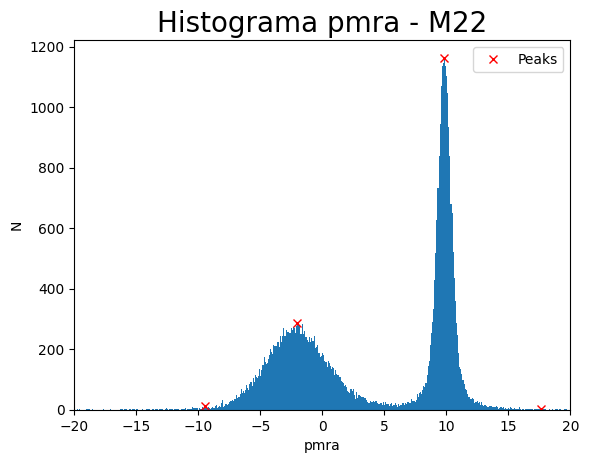

In [60]:
#with plt.style.context(['science', 'ieee']):
fig, ax = plt.subplots()
ax.hist(df_M22['pmra'], bins=1000)
plt.plot(bin_edgesM22[peaks], histo_M22[peaks], "x", label='Peaks', c='r')
ax.set_title('Histograma pmra - M22', fontsize=20)
ax.set_xlabel('pmra')
ax.set_ylabel('N')
ax.set_xlim(-20, 20)
plt.legend()
plt.show()
fig.tight_layout()
    #plt.close()

In [61]:
pmra_corr = (df_M22['pmra'] > 9) & (df_M22['pmra'] < 11)
corr_M22 = df_M22[pmra_corr]

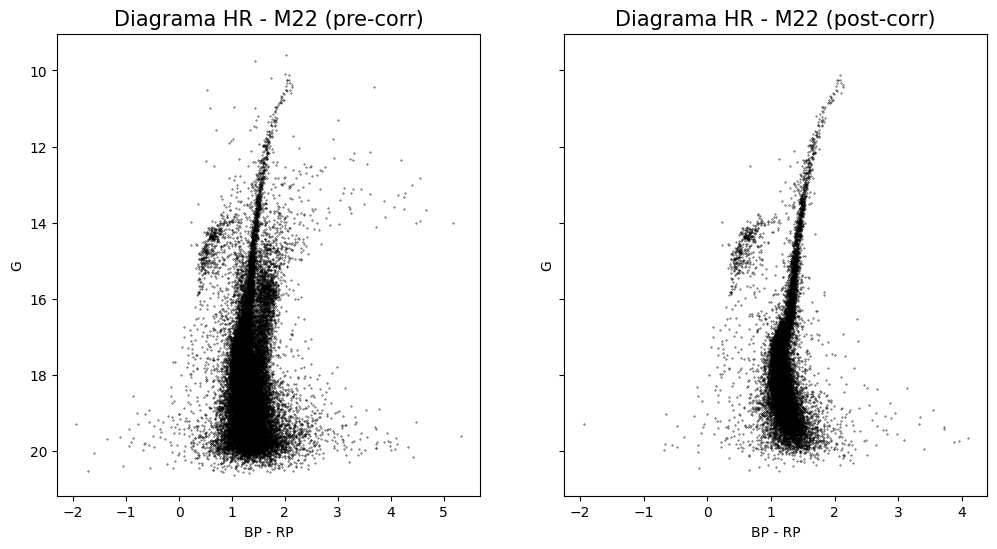

In [62]:
fig, ax = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)

ax[0].scatter(df_M22['phot_bp_mean_mag'] - df_M22['phot_rp_mean_mag'], df_M22['phot_g_mean_mag'], c='black', s=0.1)
ax[0].set_title('Diagrama HR - M22 (pre-corr)', fontsize=15)
ax[0].set_xlabel('BP - RP')
ax[0].set_ylabel('G')
ax[0].invert_yaxis()

ax[1].scatter(corr_M22['phot_bp_mean_mag'] - corr_M22['phot_rp_mean_mag'], corr_M22['phot_g_mean_mag'], c='black', s=0.1)
ax[1].set_title('Diagrama HR - M22 (post-corr)', fontsize=15)
ax[1].set_xlabel('BP - RP')
ax[1].set_ylabel('G')
#ax[1].invert_yaxis()

plt.show()
fig.tight_layout()

## Creación de una función que separe todo lo que no tenga igual pmra.

In [79]:
def detect_members(df) -> tuple:
    '''
    Escogemos los miembros del cúmulo analizando el histograma del movimiento propio en RA.
    Se utiliza find_peaks para encontrar en dónde se concentra la mayor cantidad de datos,
    y con qué RA. Luego, se filtra del dataframe para que nos quedemos solo con los miembros
    que comparten un mismo PMRA. Retorna una tupla que contiene en su primera lugar el dataframe
    filtrado y el pmra promedio del cúmulo.
    '''

    hist, bin_edges = np.histogram(df['pmra'], 1000)
    peaks, _ = find_peaks(hist, distance=80)

    for i in range(len(hist[peaks])):
        if max(hist[peaks]) == hist[peaks][i]:
            pmra_corr = bin_edges[peaks][i]

    # En vez de usar find_peaks, utilizar la mediana y definir el sigma. El único problema es que no sabemos cómo se ve el histograma!
    # IDEA: Después de analizar el plot del histograma, recibir intervalos como parámetros para luego sacar la mediana para una
    # región particular.
        
    mask = (df['pmra'] > pmra_corr - 1) & (df['pmra'] < pmra_corr + 1)

    return df[mask], pmra_corr

Probando de nuevo con M22 para ver si me da los mismos resultados.

In [64]:
test_M22, pmra_M22 = detect_members(df_M22)
print(f"El pmra con mayor frecuencia es de {pmra_M22}")

El pmra con mayor frecuencia es de 9.803197204602412


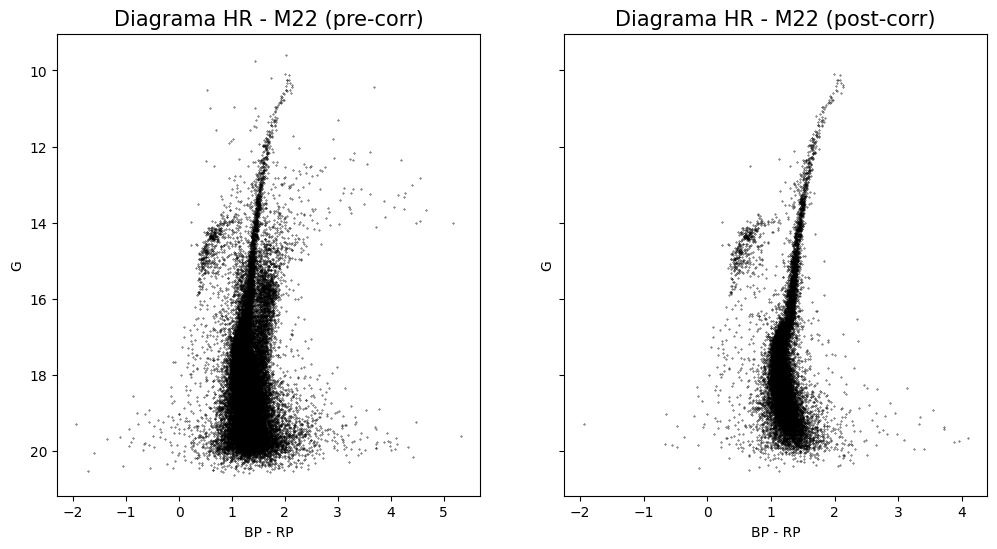

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)

ax[0].scatter(df_M22['phot_bp_mean_mag'] - df_M22['phot_rp_mean_mag'], df_M22['phot_g_mean_mag'], c='black', s=0.1)
ax[0].set_title('Diagrama HR - M22 (pre-corr)', fontsize=15)
ax[0].set_xlabel('BP - RP')
ax[0].set_ylabel('G')
ax[0].invert_yaxis()

ax[1].scatter(test_M22['phot_bp_mean_mag'] - test_M22['phot_rp_mean_mag'], test_M22['phot_g_mean_mag'], c='black', s=0.1)
ax[1].set_title('Diagrama HR - M22 (post-corr)', fontsize=15)
ax[1].set_xlabel('BP - RP')
ax[1].set_ylabel('G')
#ax[1].invert_yaxis()

plt.show()
fig.tight_layout()

## Prueba con M3.

In [66]:
for df in dfs:
    if df[0] == 'M3':
        df_M3 = df[1]

In [67]:
histo_M3, bin_edgesM3 = np.histogram(df_M3['pmra'], 1000)
peaks, _ = find_peaks(histo_M3, distance=80)

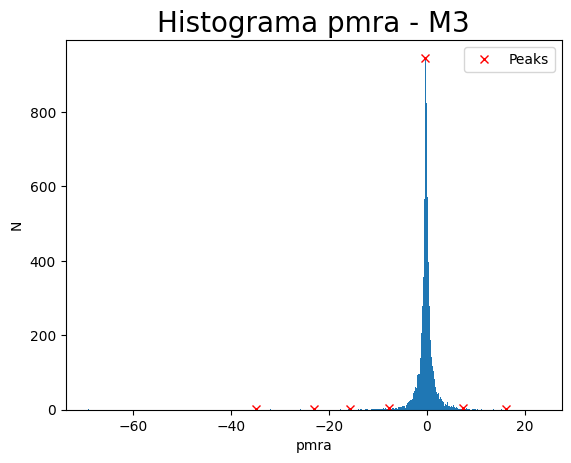

In [68]:
#with plt.style.context(['science', 'ieee']):
fig, ax = plt.subplots()
ax.hist(df_M3['pmra'], bins=1000)
plt.plot(bin_edgesM3[peaks], histo_M3[peaks], "x", label='Peaks', c='r')
ax.set_title('Histograma pmra - M3', fontsize=20)
ax.set_xlabel('pmra')
ax.set_ylabel('N')
plt.legend()
plt.show()
fig.tight_layout()
    #plt.close()

In [69]:
corr_M3, pmra_M3 = detect_members(df_M3)
print(f"El pmra con mayor frecuencia es de {pmra_M3}")

El pmra con mayor frecuencia es de -0.25576774908240907


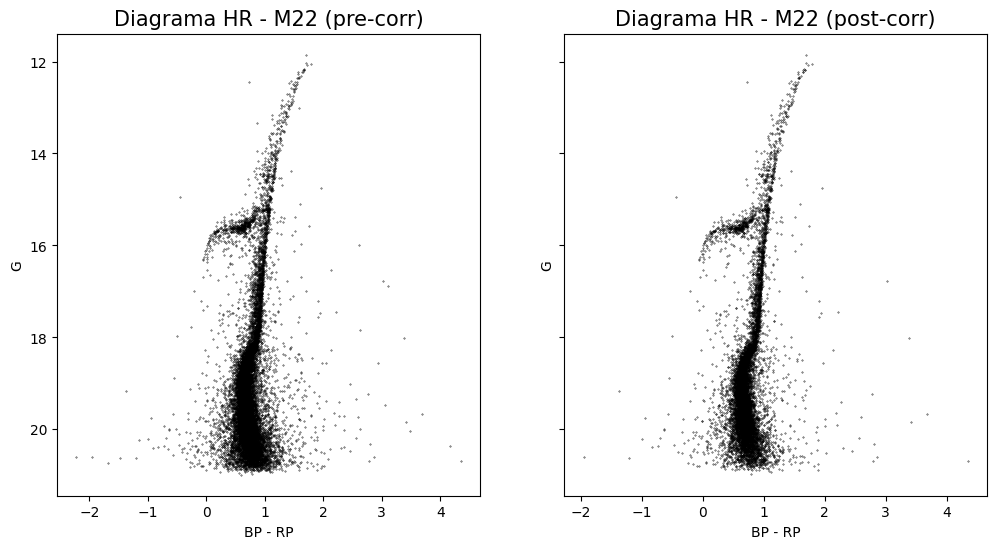

In [70]:
fig, ax = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)

ax[0].scatter(df_M3['phot_bp_mean_mag'] - df_M3['phot_rp_mean_mag'], df_M3['phot_g_mean_mag'], c='black', s=0.1)
ax[0].set_title('Diagrama HR - M22 (pre-corr)', fontsize=15)
ax[0].set_xlabel('BP - RP')
ax[0].set_ylabel('G')
ax[0].invert_yaxis()

ax[1].scatter(corr_M3['phot_bp_mean_mag'] - corr_M3['phot_rp_mean_mag'], corr_M3['phot_g_mean_mag'], c='black', s=0.1)
ax[1].set_title('Diagrama HR - M22 (post-corr)', fontsize=15)
ax[1].set_xlabel('BP - RP')
ax[1].set_ylabel('G')
#ax[1].invert_yaxis()
plt.show()
fig.tight_layout()

# Función para graficar los diagramas HR pre-corrección y post-corrección.

In [91]:
def graph_hr(df, corr_df, ID):
    '''
    Sirve para graficar los diagramas HR de los cúmulos pre y post corrección. Tienes
    que entregarle el dataframe del cúmulo posterior (df) y el posterior (corr) y 
    el nombre del cúmulo.
    '''
    fig, ax = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)

    ax[0].scatter(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'], df['phot_g_mean_mag'], c='black', s=0.1)
    ax[0].set_title(f'Diagrama HR - {ID} (pre-corr)', fontsize=15)
    ax[0].set_xlabel('BP - RP')
    ax[0].set_ylabel('G')
    ax[0].invert_yaxis()

    ax[1].scatter(corr_df['phot_bp_mean_mag'] - corr_df['phot_rp_mean_mag'], corr_df['phot_g_mean_mag'], c='black', s=0.1)
    ax[1].set_title(f'Diagrama HR - {ID} (post-corr)', fontsize=15)
    ax[1].set_xlabel('BP - RP')
    ax[1].set_ylabel('G')
    
    fig.tight_layout()
    plt.savefig(f'figures_correction/{ID}_corrected.jpg')
    #plt.show()
    

# Separación de todos los demás cúmulos.

In [92]:
for df in dfs:
    df_corr, pmra_corr = detect_members(df[1])
    graph_hr(df[1], df_corr, df[0])